# Impact of Article Exposure on Personas: Relevance, Sentiment, and Agreement

This notebook aims to analyze the impact of exposing personas to articles with respect to three key metrics: relevance, sentiment, and agreement on various topics from a questionnaire. Additionally, we will explore whether showing articles aligned with the personas' initial beliefs leads to radicalization (i.e., reinforcement of those beliefs).


## Data Preparation

In [31]:
import json
import pandas as pd

# Load before_responses.json
with open('../data/processed/before_responses.json', 'r') as f:
    before_responses = json.load(f)

# Load after_responses.json
with open('../data/processed/after_responses.json', 'r') as f:
    after_responses = json.load(f)

# Convert JSON data to DataFrames
before_df = pd.json_normalize(before_responses)
after_df = pd.json_normalize(after_responses)

# Keep only necessary columns and rename them for clarity
before_df = before_df[['user_id', 'question', 'response.sentiment', 'response.relevance', 'response.agreement']].rename(
    columns={'response.sentiment': 'before_sentiment', 'response.relevance': 'before_relevance', 'response.agreement': 'before_agreement'})
after_df = after_df[['user_id', 'question', 'response.sentiment', 'response.relevance', 'response.agreement', 'article.sentiment']].rename(
    columns={'response.sentiment': 'after_sentiment', 'response.relevance': 'after_relevance', 'response.agreement': 'after_agreement', 'article.sentiment': 'article_sentiment'})

# Merge before and after responses on user_id and question
merged_df = pd.merge(before_df, after_df, on=['user_id', 'question'])

# Convert sentiments, relevance, and agreement to numeric where applicable
merged_df['before_sentiment'] = pd.to_numeric(merged_df['before_sentiment'], errors='coerce')
merged_df['after_sentiment'] = pd.to_numeric(merged_df['after_sentiment'], errors='coerce')
merged_df['before_relevance'] = pd.to_numeric(merged_df['before_relevance'], errors='coerce')
merged_df['after_relevance'] = pd.to_numeric(merged_df['after_relevance'], errors='coerce')
merged_df['before_agreement'] = pd.to_numeric(merged_df['before_agreement'], errors='coerce')
merged_df['after_agreement'] = pd.to_numeric(merged_df['after_agreement'], errors='coerce')
merged_df['article_sentiment'] = merged_df['article_sentiment'].map({'positive': 5, 'neutral': 3, 'negative': 1})

# Calculate the shifts
merged_df['relevance_shift'] = merged_df['after_relevance'] - merged_df['before_relevance']
merged_df['sentiment_shift'] = merged_df['after_sentiment'] - merged_df['before_sentiment']
merged_df['agreement_shift'] = merged_df['after_agreement'] - merged_df['before_agreement']

# Determine if the article sentiment aligns with the initial sentiment
merged_df['alignment'] = (
    (merged_df['before_sentiment'] >= 4) & (merged_df['article_sentiment'] == 5) |
    (merged_df['before_sentiment'] <= 2) & (merged_df['article_sentiment'] == 1)
)

# Define the threshold for positive sentiment
positive_sentiment_threshold = 3

# Separate positive and negative articles based on the article_sentiment
merged_df['is_positive'] = merged_df['article_sentiment'] > positive_sentiment_threshold

# Group by user_id and is_positive, then calculate the mean for sentiment, relevance, and agreement
averaged_df = merged_df.groupby(['user_id', 'is_positive'])[['after_sentiment', 'after_relevance', 'after_agreement']].mean().unstack()

# Flatten the MultiIndex columns for clarity
averaged_df.columns = ['average_negative_sentiment', 'average_positive_sentiment',
                       'average_negative_relevance', 'average_positive_relevance',
                       'average_negative_agreement', 'average_positive_agreement']

# Fill NaN values with 0 (or any other desired value, e.g., the neutral sentiment)
averaged_df = averaged_df.fillna(0)



# Load the combined data
combined_data = pd.read_csv('../data/processed/combined_data.csv')

# Extract relevant columns (user_id and political position)
political_data = combined_data[['user', 'Where would you place your own political position?']]

# Rename columns for easier access
political_data = political_data.rename(columns={
    'user': 'user_id',
    'Where would you place your own political position?': 'political_position'
})

# Merge political position into merged_df
merged_df = pd.merge(merged_df, political_data[['user_id', 'political_position']], on='user_id', how='left')

# Verify the merge
print(merged_df.columns)  # Ensure 'political_position' is now part of merged_df


Index(['user_id', 'question', 'before_sentiment', 'before_relevance',
       'before_agreement', 'after_sentiment', 'after_relevance',
       'after_agreement', 'article_sentiment', 'relevance_shift',
       'sentiment_shift', 'agreement_shift', 'alignment', 'is_positive',
       'political_position'],
      dtype='object')


In [33]:
merged_df['political_position'] = merged_df['political_position'].replace({
    'Far Left': 'Left', 
    'Extreme Left': 'Left'
})

# Verify the result by checking the value counts again
print(merged_df['political_position'].value_counts())

political_position
Extreme Right    35601
Left             26145
Name: count, dtype: int64


## Analysis of Impact

### Relevance Shift Analysis

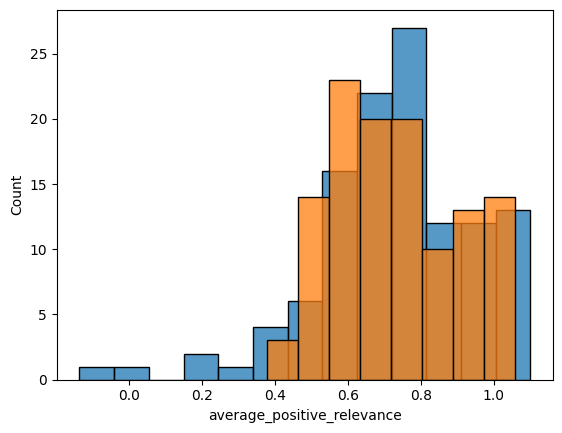

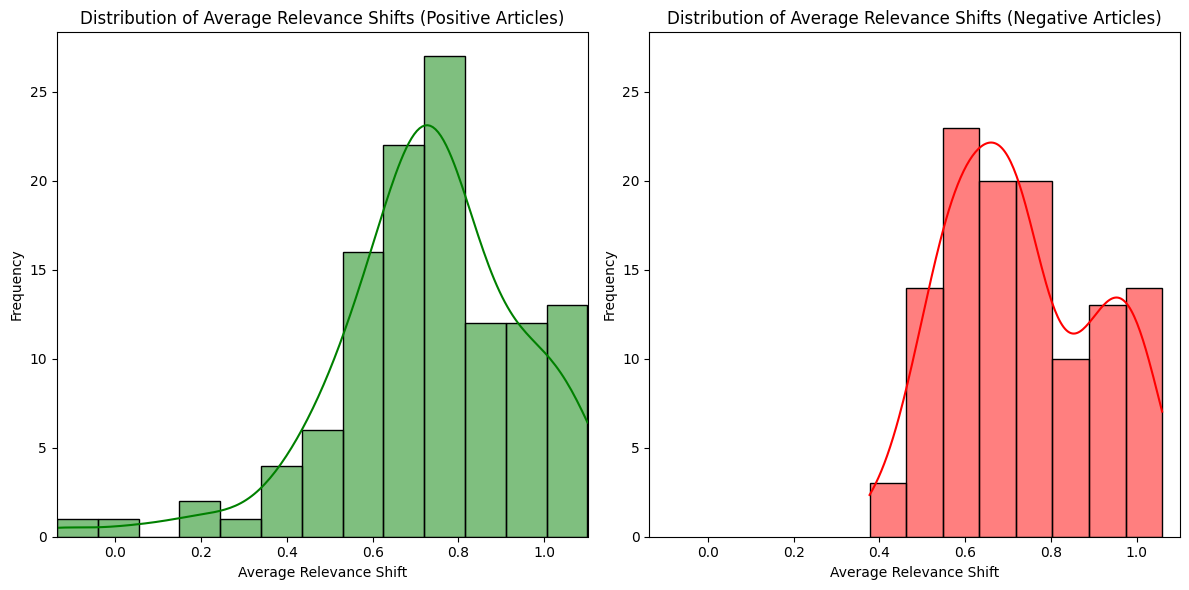

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average relevance shift for each persona
average_relevance_shift_positive = averaged_df['average_positive_relevance'] - merged_df['before_relevance'].mean()
average_relevance_shift_negative = averaged_df['average_negative_relevance'] - merged_df['before_relevance'].mean()

# Find common limits for x-axis and y-axis
x_min = min(average_relevance_shift_positive.min(), average_relevance_shift_negative.min())
x_max = max(average_relevance_shift_positive.max(), average_relevance_shift_negative.max())
y_max = max(
    sns.histplot(average_relevance_shift_positive.dropna(), kde=False).get_figure().axes[0].get_ylim()[1],
    sns.histplot(average_relevance_shift_negative.dropna(), kde=False).get_figure().axes[0].get_ylim()[1]
)

# Plotting average relevance shift distribution
plt.figure(figsize=(12, 6))

# Subplot 1: Average relevance shift after positive articles
plt.subplot(1, 2, 1)
sns.histplot(average_relevance_shift_positive.dropna(), kde=True, color='green')
plt.title('Distribution of Average Relevance Shifts (Positive Articles)')
plt.xlabel('Average Relevance Shift')
plt.ylabel('Frequency')
plt.xlim(x_min, x_max)  # Set the same x-axis limits
plt.ylim(0, y_max)      # Set the same y-axis limits

# Subplot 2: Average relevance shift after negative articles
plt.subplot(1, 2, 2)
sns.histplot(average_relevance_shift_negative.dropna(), kde=True, color='red')
plt.title('Distribution of Average Relevance Shifts (Negative Articles)')
plt.xlabel('Average Relevance Shift')
plt.ylabel('Frequency')
plt.xlim(x_min, x_max)  # Set the same x-axis limits
plt.ylim(0, y_max)      # Set the same y-axis limits

plt.tight_layout()
plt.show()


Positive Articles: Participants exposed to positive articles generally experienced a higher relevance shift, centered around 0.8.
Negative Articles: Those exposed to negative articles generally experienced a slightly lower relevance shift, centered around 0.6-0.7

### Sentiment Shift Analysis

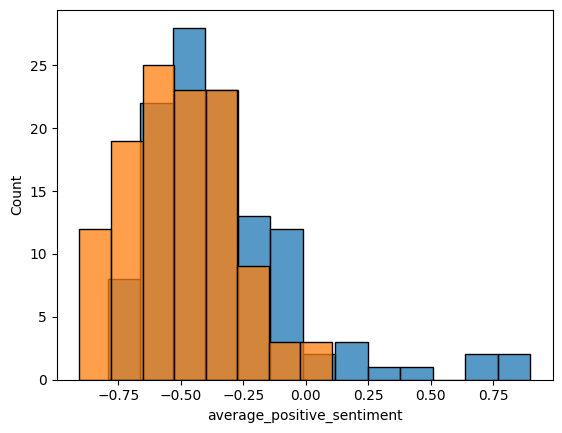

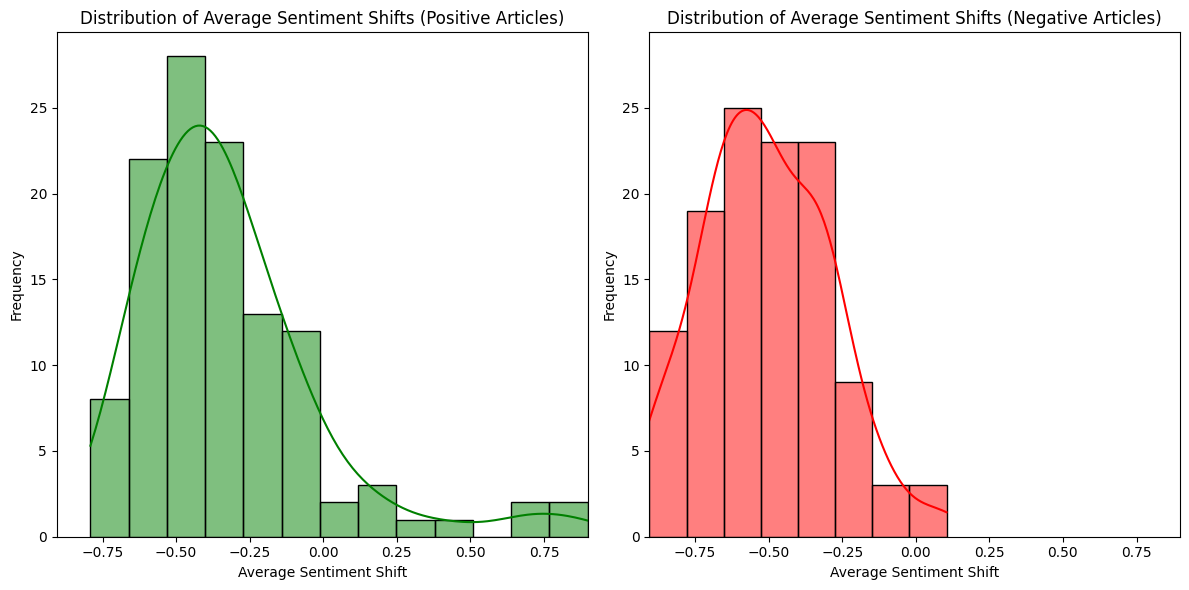

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average sentiment shift for each persona, for positive and negative articles
average_sentiment_shift_positive = averaged_df['average_positive_sentiment'] - merged_df['before_sentiment'].mean()
average_sentiment_shift_negative = averaged_df['average_negative_sentiment'] - merged_df['before_sentiment'].mean()

# Find common limits for x-axis and y-axis
x_min = min(average_sentiment_shift_positive.min(), average_sentiment_shift_negative.min())
x_max = max(average_sentiment_shift_positive.max(), average_sentiment_shift_negative.max())
y_max = max(
    sns.histplot(average_sentiment_shift_positive.dropna(), kde=False).get_figure().axes[0].get_ylim()[1],
    sns.histplot(average_sentiment_shift_negative.dropna(), kde=False).get_figure().axes[0].get_ylim()[1]
)

# Plotting average sentiment shift distribution
plt.figure(figsize=(12, 6))

# Subplot 1: Average sentiment shift after positive articles
plt.subplot(1, 2, 1)
sns.histplot(average_sentiment_shift_positive.dropna(), kde=True, color='green')
plt.title('Distribution of Average Sentiment Shifts (Positive Articles)')
plt.xlabel('Average Sentiment Shift')
plt.ylabel('Frequency')
plt.xlim(x_min, x_max)  # Set the same x-axis limits
plt.ylim(0, y_max)      # Set the same y-axis limits

# Subplot 2: Average sentiment shift after negative articles
plt.subplot(1, 2, 2)
sns.histplot(average_sentiment_shift_negative.dropna(), kde=True, color='red')
plt.title('Distribution of Average Sentiment Shifts (Negative Articles)')
plt.xlabel('Average Sentiment Shift')
plt.ylabel('Frequency')
plt.xlim(x_min, x_max)  # Set the same x-axis limits
plt.ylim(0, y_max)      # Set the same y-axis limits

plt.tight_layout()
plt.show()


The agents exposed to positive articles have mostly experienced a sentiment shift in the negative direction (avg around -0.5) with some outliers experiencing an increase in sentiment, agents exposed to negative article show more substantial shifts towards negative sentiments, averaging at around -0.6

### Agreement Shift Analysis

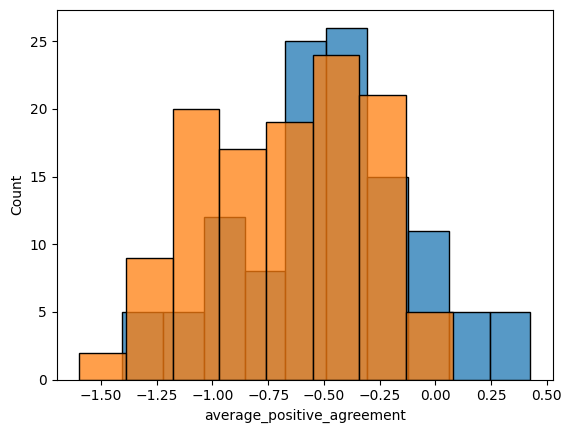

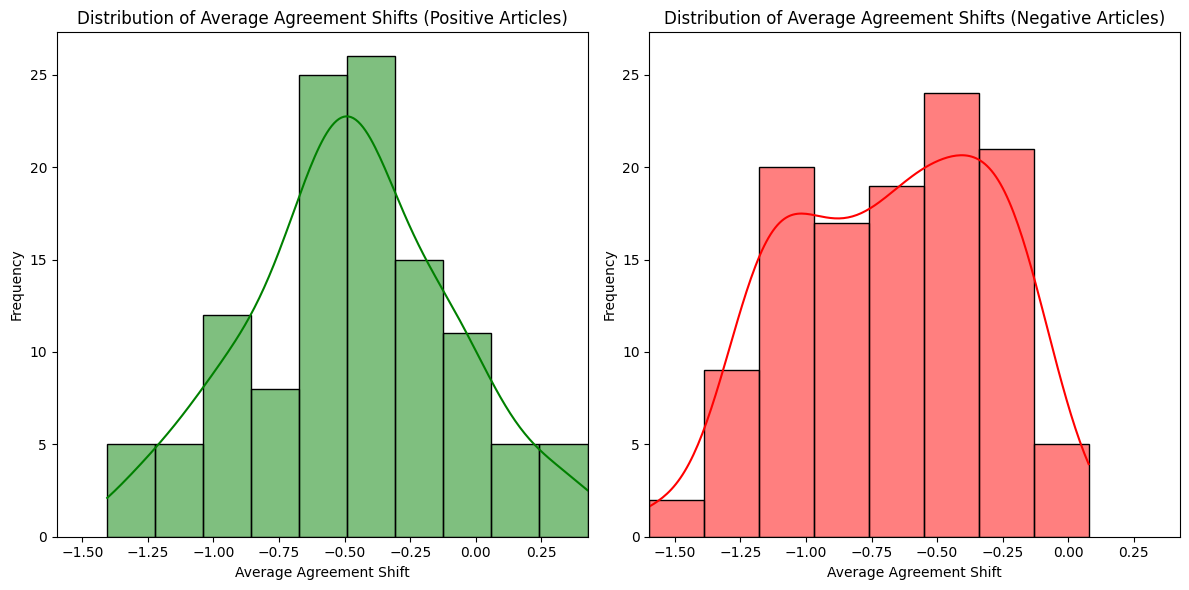

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where 'after_agreement' or 'before_agreement' are missing
valid_agreement_df = merged_df.dropna(subset=['after_agreement', 'before_agreement'])

# Calculate the average agreement shift for each persona, for positive and negative articles
average_agreement_shift_positive = averaged_df['average_positive_agreement'] - valid_agreement_df['before_agreement'].mean()
average_agreement_shift_negative = averaged_df['average_negative_agreement'] - valid_agreement_df['before_agreement'].mean()

# Find common limits for x-axis and y-axis
x_min = min(average_agreement_shift_positive.min(), average_agreement_shift_negative.min())
x_max = max(average_agreement_shift_positive.max(), average_agreement_shift_negative.max())
y_max = max(
    sns.histplot(average_agreement_shift_positive.dropna(), kde=False).get_figure().axes[0].get_ylim()[1],
    sns.histplot(average_agreement_shift_negative.dropna(), kde=False).get_figure().axes[0].get_ylim()[1]
)

# Plotting average agreement shift distribution
plt.figure(figsize=(12, 6))

# Subplot 1: Average agreement shift after positive articles
plt.subplot(1, 2, 1)
sns.histplot(average_agreement_shift_positive.dropna(), kde=True, color='green')
plt.title('Distribution of Average Agreement Shifts (Positive Articles)')
plt.xlabel('Average Agreement Shift')
plt.ylabel('Frequency')
plt.xlim(x_min, x_max)  # Set the same x-axis limits
plt.ylim(0, y_max)      # Set the same y-axis limits

# Subplot 2: Average agreement shift after negative articles
plt.subplot(1, 2, 2)
sns.histplot(average_agreement_shift_negative.dropna(), kde=True, color='red')
plt.title('Distribution of Average Agreement Shifts (Negative Articles)')
plt.xlabel('Average Agreement Shift')
plt.ylabel('Frequency')
plt.xlim(x_min, x_max)  # Set the same x-axis limits
plt.ylim(0, y_max)      # Set the same y-axis limits

plt.tight_layout()
plt.show()


The agreement tends to decrease to decrease both when agents are exposed to positive and negative articles. There are few outliers among the agents exposed to positive articles where the agreement increases slightly. 

### Statistical Significance Tests


In [37]:
from scipy.stats import wilcoxon

# Calculate the average relevance, sentiment, and agreement shifts as before
# (assuming this is already done in the earlier code you provided)

# Statistical Tests

# Relevance Shifts
relevance_shift_test_positive = wilcoxon(averaged_df['average_positive_relevance'].dropna() - merged_df['before_relevance'].mean(), alternative='two-sided')
relevance_shift_test_negative = wilcoxon(averaged_df['average_negative_relevance'].dropna() - merged_df['before_relevance'].mean(), alternative='two-sided')

# Sentiment Shifts
sentiment_shift_test_positive = wilcoxon(averaged_df['average_positive_sentiment'].dropna() - merged_df['before_sentiment'].mean(), alternative='two-sided')
sentiment_shift_test_negative = wilcoxon(averaged_df['average_negative_sentiment'].dropna() - merged_df['before_sentiment'].mean(), alternative='two-sided')

# Agreement Shifts
agreement_shift_test_positive = wilcoxon(averaged_df['average_positive_agreement'].dropna() - valid_agreement_df['before_agreement'].mean(), alternative='two-sided')
agreement_shift_test_negative = wilcoxon(averaged_df['average_negative_agreement'].dropna() - valid_agreement_df['before_agreement'].mean(), alternative='two-sided')

# Print Results
print("### Wilcoxon Test Results for Relevance Shifts")
print("- **Positive Articles**: ")
print(f"  - Statistic: {relevance_shift_test_positive.statistic:.1f}")
print(f"  - p-value: {relevance_shift_test_positive.pvalue:.2e}")
print("- **Negative Articles**: ")
print(f"  - Statistic: {relevance_shift_test_negative.statistic:.1f}")
print(f"  - p-value: {relevance_shift_test_negative.pvalue:.2e}")

print("\n### Wilcoxon Test Results for Sentiment Shifts")
print("- **Positive Articles**: ")
print(f"  - Statistic: {sentiment_shift_test_positive.statistic:.1f}")
print(f"  - p-value: {sentiment_shift_test_positive.pvalue:.2e}")
print("- **Negative Articles**: ")
print(f"  - Statistic: {sentiment_shift_test_negative.statistic:.1f}")
print(f"  - p-value: {sentiment_shift_test_negative.pvalue:.2e}")

print("\n### Wilcoxon Test Results for Agreement Shifts")
print("- **Positive Articles**: ")
print(f"  - Statistic: {agreement_shift_test_positive.statistic:.1f}")
print(f"  - p-value: {agreement_shift_test_positive.pvalue:.2e}")
print("- **Negative Articles**: ")
print(f"  - Statistic: {agreement_shift_test_negative.statistic:.1f}")
print(f"  - p-value: {agreement_shift_test_negative.pvalue:.2e}")

### Wilcoxon Test Results for Relevance Shifts
- **Positive Articles**: 
  - Statistic: 2.0
  - p-value: 6.47e-21
- **Negative Articles**: 
  - Statistic: 0.0
  - p-value: 6.15e-21

### Wilcoxon Test Results for Sentiment Shifts
- **Positive Articles**: 
  - Statistic: 626.0
  - p-value: 1.53e-14
- **Negative Articles**: 
  - Statistic: 5.0
  - p-value: 6.99e-21

### Wilcoxon Test Results for Agreement Shifts
- **Positive Articles**: 
  - Statistic: 277.0
  - p-value: 5.92e-18
- **Negative Articles**: 
  - Statistic: 3.0
  - p-value: 6.64e-21



#### Conclusion
The analysis confirms that exposure to both positive and negative articles results in statistically significant shifts in relevance, sentiment, and agreement among the generative agents. The low p-values across all tests suggest that these shifts are not due to random chance and are strongly influenced by the content of the articles.

## Radicalization Analysis

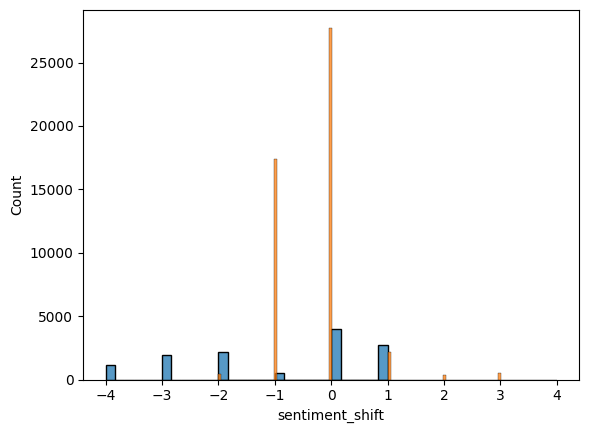

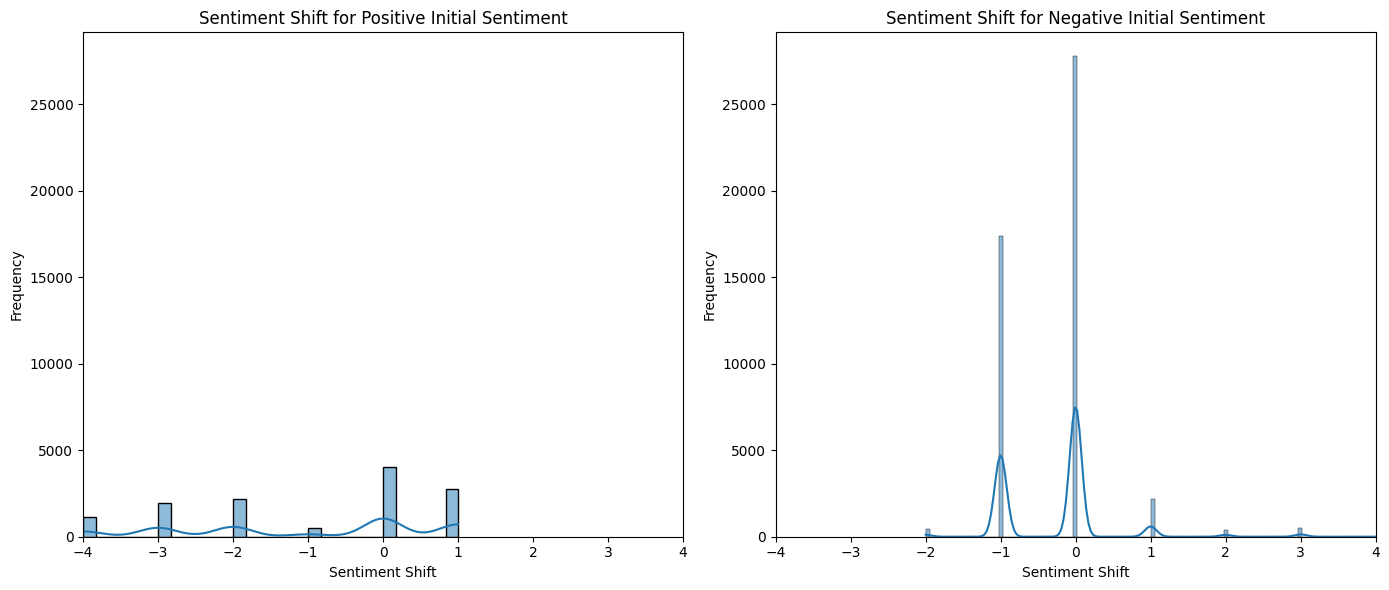

Wilcoxon Signed-Rank Test for Positive Initial Sentiment:
Statistic: 4452630.0, p-value: 1.0
Wilcoxon Signed-Rank Test for Negative Initial Sentiment:
Statistic: 39604279.5, p-value: 0.0


In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

positive_initial_sentiment = merged_df['before_sentiment'] > 3
negative_initial_sentiment = merged_df['before_sentiment'] <= 3

# Filter data for sentiment shifts
positive_sentiment_shift = merged_df[positive_initial_sentiment]['sentiment_shift'].dropna()
negative_sentiment_shift = merged_df[negative_initial_sentiment]['sentiment_shift'].dropna()

# Find common limits for x-axis and y-axis
x_min = min(positive_sentiment_shift.min(), negative_sentiment_shift.min())
x_max = max(positive_sentiment_shift.max(), negative_sentiment_shift.max())
y_max = max(
    sns.histplot(positive_sentiment_shift, kde=False).get_figure().axes[0].get_ylim()[1],
    sns.histplot(negative_sentiment_shift, kde=False).get_figure().axes[0].get_ylim()[1]
)

# Plot sentiment shifts for both groups
plt.figure(figsize=(14, 6))

# Subplot 1: Sentiment shift for positive initial sentiment
plt.subplot(1, 2, 1)
sns.histplot(positive_sentiment_shift, kde=True)
plt.title('Sentiment Shift for Positive Initial Sentiment')
plt.xlabel('Sentiment Shift')
plt.ylabel('Frequency')
plt.xlim(x_min, x_max)  # Set the same x-axis limits
plt.ylim(0, y_max)      # Set the same y-axis limits

# Subplot 2: Sentiment shift for negative initial sentiment
plt.subplot(1, 2, 2)
sns.histplot(negative_sentiment_shift, kde=True)
plt.title('Sentiment Shift for Negative Initial Sentiment')
plt.xlabel('Sentiment Shift')
plt.ylabel('Frequency')
plt.xlim(x_min, x_max)  # Set the same x-axis limits
plt.ylim(0, y_max)      # Set the same y-axis limits

plt.tight_layout()
plt.show()

# Perform the Wilcoxon Signed-Rank Test

# Test for reinforcement in the positive sentiment group
if len(positive_sentiment_shift) > 1:
    positive_test_result = wilcoxon(positive_sentiment_shift, alternative='greater')
    print("Wilcoxon Signed-Rank Test for Positive Initial Sentiment:")
    print(f"Statistic: {positive_test_result.statistic}, p-value: {positive_test_result.pvalue}")
else:
    print("Not enough data to perform the test for positive sentiment shift.")

# Test for reinforcement in the negative sentiment group
if len(negative_sentiment_shift) > 1:
    negative_test_result = wilcoxon(negative_sentiment_shift, alternative='less')
    print("Wilcoxon Signed-Rank Test for Negative Initial Sentiment:")
    print(f"Statistic: {negative_test_result.statistic}, p-value: {negative_test_result.pvalue}")
else:
    print("Not enough data to perform the test for negative sentiment shift.")


#### Reinforcement Evidence:

**Positive Initial Sentiment Group**: The generative agents with positive initial sentiment did not show consistent reinforcement. The data revealed a mix of no change and negative shifts, resulting in a high p-value. This suggests that exposure to positive articles did not strongly reinforce their existing positive views.


**Negative Initial Sentiment Group**: The generative agents with negative initial sentiment exhibited more consistent negative shifts, which aligns with the hypothesis of reinforcement. However, there were also unexpected positive shifts observed in some cases.
#### Potential Issues:

**Neutral Shifts**: A significant number of agents experienced no change in sentiment (zero shifts), complicating the interpretation. This could indicate that the articles often had no impact on the agents or that their initial sentiments were resilient to change.


**Unexpected Positive Shifts in the Negative Group**: The presence of positive shifts among agents with initially negative sentiment might be due to factors such as the articles not being strongly negative or the agents re-evaluating their initial stance.

#### Conclusion

The analysis reveals that exposing generative agents to articles does influence sentiment, though not always in the expected direction. Specifically, agents with negative initial sentiment showed more consistent negative shifts, suggesting reinforcement of their existing views. However, agents with positive initial sentiment did not consistently reinforce their positive views; instead, they exhibited a mix of no change and negative shifts.

The high frequency of neutral shifts (no change) suggests that the articles often had little impact on sentiment or that the agents' initial sentiments were resistant to change. Additionally, the presence of some positive shifts in the negative group highlights a potential complexity in how agents interpret and respond to article content.

## Further Exploration

In [25]:
#TODO: add the political stance to merged_df... right now, it has a different name, like a question, but it should be turned into the name "political_position"

In [39]:
# Average the 'after_' responses and other relevant fields by user_id
grouped_df = merged_df.groupby(['user_id', 'political_position']).agg({
    'after_sentiment': 'mean',
    'after_relevance': 'mean',
    'after_agreement': 'mean',
    'before_sentiment': 'mean',
    'before_relevance': 'mean',
    'before_agreement': 'mean',
    'relevance_shift': 'mean',
    'sentiment_shift': 'mean',
    'agreement_shift': 'mean'
}).reset_index()

# Verify the new grouped_df
print(grouped_df.head())


      user_id political_position  after_sentiment  after_relevance  \
0  IDUS103408      Extreme Right         2.171076         4.497354   
1  IDUS103554      Extreme Right         1.945017         4.697595   
2  IDUS103826      Extreme Right         1.926316         4.550877   
3  IDUS104424               Left         1.847666         4.624079   
4  IDUS104462      Extreme Right         2.089347         4.594502   

   after_agreement  before_sentiment  before_relevance  before_agreement  \
0         2.641651          2.527972          3.856643          2.897233   
1         2.711806          2.340206          3.927835          3.366300   
2         2.637546          2.444444          4.062500          3.326360   
3         2.028278          2.139706          3.615196          2.908824   
4         2.362319          2.536082          3.876289          2.745098   

   relevance_shift  sentiment_shift  agreement_shift  
0         0.624339        -0.343915        -0.235529  
1         0.

In [43]:
# Combine 'Far Left' and 'Extreme Left' into a single category 'Left'
grouped_df['political_position'] = grouped_df['political_position'].replace({
    'Far Left': 'Left',
    'Extreme Left': 'Left'
})

# Verify the replacement
print(grouped_df.value_counts())  # Check the updated counts for each political position


user_id     political_position  after_sentiment  after_relevance  after_agreement  before_sentiment  before_relevance  before_agreement  relevance_shift  sentiment_shift  agreement_shift
IDUS103408  Extreme Right       2.171076         4.497354         2.641651         2.527972          3.856643          2.897233          0.624339         -0.343915        -0.235529          1
IDUS103554  Extreme Right       1.945017         4.697595         2.711806         2.340206          3.927835          3.366300          0.769759         -0.395189        -0.582418          1
IDUS103826  Extreme Right       1.926316         4.550877         2.637546         2.444444          4.062500          3.326360          0.487719         -0.522807        -0.592050          1
IDUS104424  Left                1.847666         4.624079         2.028278         2.139706          3.615196          2.908824          1.009828         -0.292383        -0.802360          1
IDUS104462  Extreme Right       2.089347     

In [ ]:
## Maybe since there is  no Left in the original data, if we try to calculate the difference before the before responses and after respponses, we will get NaN values.

#### Average Sentiment Shift by Political Position

political_position
Extreme Right    68
Left             49
Name: count, dtype: int64
political_position
Extreme Right   -0.502622
Left            -0.335758
Name: sentiment_shift, dtype: float64


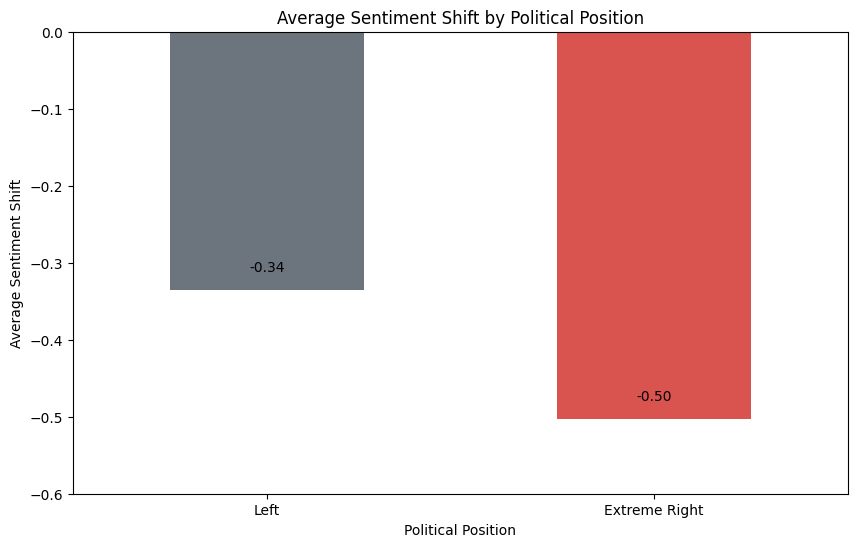

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

print(grouped_df["political_position"].value_counts())
# Calculate the average sentiment shift by political position
political_position_effect = grouped_df.groupby('political_position')['sentiment_shift'].mean()

# Check if 'Left' and 'Extreme Right' are both present in the data
print(political_position_effect)

# Ensure both 'Left' and 'Extreme Right' are present, even if one is missing
expected_categories = ['Left', 'Extreme Right']
for category in expected_categories:
    if category not in political_position_effect.index:
        political_position_effect[category] = 0  # Set missing categories to 0 or NaN

# Re-sort the index to ensure the order is consistent
political_position_effect = political_position_effect.reindex(expected_categories)

# Create the bar plot with a more subdued color palette
plt.figure(figsize=(10, 6))

# Use a neutral color palette
colors = ['#6C757D', '#D9534F']  # Soft gray and muted red for 'Left' and 'Extreme Right'

# Plot the bar chart
political_position_effect.plot(kind='bar', color=colors, rot=0)

# Customizing the y-axis
plt.ylim(-0.6, 0)  # Adjust y-axis limits for better visualization

# Adding labels and title
plt.title('Average Sentiment Shift by Political Position')
plt.xlabel('Political Position')
plt.ylabel('Average Sentiment Shift')

# Annotating each bar with the value
for index, value in enumerate(political_position_effect):
    plt.text(index, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()


On average, agents with an extreme-right persona tend towards a sentiment decrease, regardless of the article's sentiment.

Number of entries with aligned positive articles (before averaging): 6903
Number of entries with aligned positive articles (after averaging): 113
Number of sentiment shifts calculated: 113


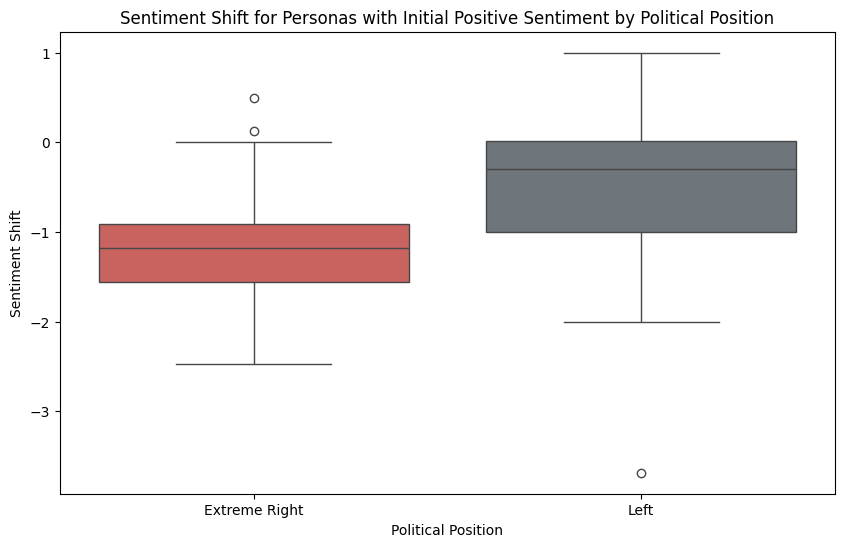

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Step 1: Combine 'Extreme Left' and 'Far Left' into 'Left'
merged_df['political_position'] = merged_df['political_position'].replace({
    'Far Left': 'Left',
    'Extreme Left': 'Left'
})

# Step 2: Filter personas with initial positive sentiment
positive_sentiment_threshold = 3  # Adjust based on your scale
initial_positive = merged_df[merged_df['before_sentiment'] > positive_sentiment_threshold]

# Step 3: Filter aligned articles based on numeric value
aligned_positive = initial_positive[initial_positive['article_sentiment'] > positive_sentiment_threshold]

# Debug: Check the size of the aligned articles before averaging
print(f"Number of entries with aligned positive articles (before averaging): {aligned_positive.shape[0]}")

# Step 4: Group by 'user_id' and 'political_position' to calculate the average sentiment shift
aligned_positive_grouped = aligned_positive.groupby(['user_id', 'political_position']).agg({
    'before_sentiment': 'mean',
    'after_sentiment': 'mean'
}).reset_index()

# Debug: Check the size of the aligned articles after averaging
print(f"Number of entries with aligned positive articles (after averaging): {aligned_positive_grouped.shape[0]}")

# Calculate the sentiment shift after averaging
aligned_positive_grouped['sentiment_shift'] = aligned_positive_grouped['after_sentiment'] - aligned_positive_grouped['before_sentiment']

# Debug: Check if there are any shifts
print(f"Number of sentiment shifts calculated: {aligned_positive_grouped['sentiment_shift'].count()}")

# Step 5: Analyze the sentiment shifts by political position using the specified color palette
if not aligned_positive_grouped.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='political_position', y='sentiment_shift', hue='political_position', 
                data=aligned_positive_grouped, 
                palette={'Left': '#6C757D', 'Extreme Right': '#D9534F'})
    plt.title('Sentiment Shift for Personas with Initial Positive Sentiment by Political Position')
    plt.xlabel('Political Position')
    plt.ylabel('Sentiment Shift')
    plt.legend([], [], frameon=False)  # Hide the legend as it duplicates the x-axis labels
    plt.show()
else:
    print("No data available for plotting.")


Agents with an extreme right persona who had an initial positive sentiment tend to decrease their initial sentiment after exposure to positive news articles. Left-aligned personas tend to keep their sentiment consistent with their previous views. I.e. positive-sentiment articles do not increase polarization in agents. (this might also be due to the content of the articles though)

Number of entries with aligned negative articles (before averaging): 26141
Number of entries with aligned negative articles (after averaging): 117
Number of sentiment shifts calculated: 117


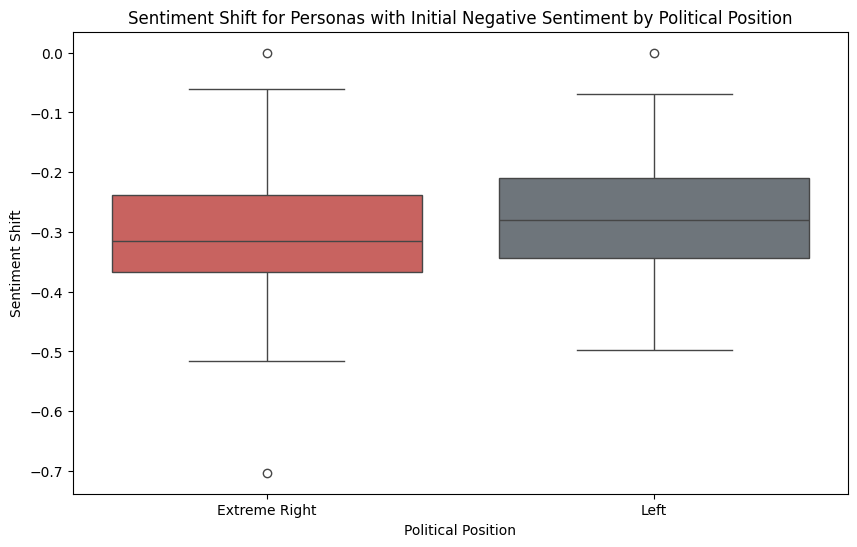

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming previous steps like loading data, merging political positions, etc., are done

# Step 1: Combine 'Extreme Left' and 'Far Left' into 'Left'
merged_df['political_position'] = merged_df['political_position'].replace({
    'Far Left': 'Left',
    'Extreme Left': 'Left'
})

# Step 2: Filter personas with initial negative sentiment
negative_sentiment_threshold = 3  # Adjust based on your scale
initial_negative = merged_df[merged_df['before_sentiment'] <= negative_sentiment_threshold]

# Step 3: Filter aligned articles based on numeric value
aligned_negative = initial_negative[initial_negative['article_sentiment'] <= negative_sentiment_threshold]

# Debug: Check the size of the aligned articles before averaging
print(f"Number of entries with aligned negative articles (before averaging): {aligned_negative.shape[0]}")

# Step 4: Group by 'user_id' and 'political_position' to calculate the average sentiment shift
aligned_negative_grouped = aligned_negative.groupby(['user_id', 'political_position']).agg({
    'before_sentiment': 'mean',
    'after_sentiment': 'mean'
}).reset_index()

# Debug: Check the size of the aligned articles after averaging
print(f"Number of entries with aligned negative articles (after averaging): {aligned_negative_grouped.shape[0]}")

# Calculate the sentiment shift after averaging
aligned_negative_grouped['sentiment_shift'] = aligned_negative_grouped['after_sentiment'] - aligned_negative_grouped['before_sentiment']

# Debug: Check if there are any shifts
print(f"Number of sentiment shifts calculated: {aligned_negative_grouped['sentiment_shift'].count()}")

# Step 5: Analyze the sentiment shifts by political position using the specified color palette
if not aligned_negative_grouped.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='political_position', y='sentiment_shift', hue='political_position', 
                data=aligned_negative_grouped, 
                palette={'Left': '#6C757D', 'Extreme Right': '#D9534F'})
    plt.title('Sentiment Shift for Personas with Initial Negative Sentiment by Political Position')
    plt.xlabel('Political Position')
    plt.ylabel('Sentiment Shift')
    plt.legend([], [], frameon=False)  # Hide the legend as it duplicates the x-axis labels
    plt.show()
else:
    print("No data available for plotting.")


In both groups, if the initial sentiment was negative, after exposure to news articles, it tends to further decrease, even if slightly. This might hint to a negative polarization if agents are shown articles aligned with their previous views.

### Which Questions are most susceptible to sentiment shifts?

Political position distribution before grouping:
political_position
Extreme Right    35601
Left             26145
Name: count, dtype: int64
Grouped Data (question_level_shifts):
political_position
Extreme Right    17
Left             17
Name: count, dtype: int64


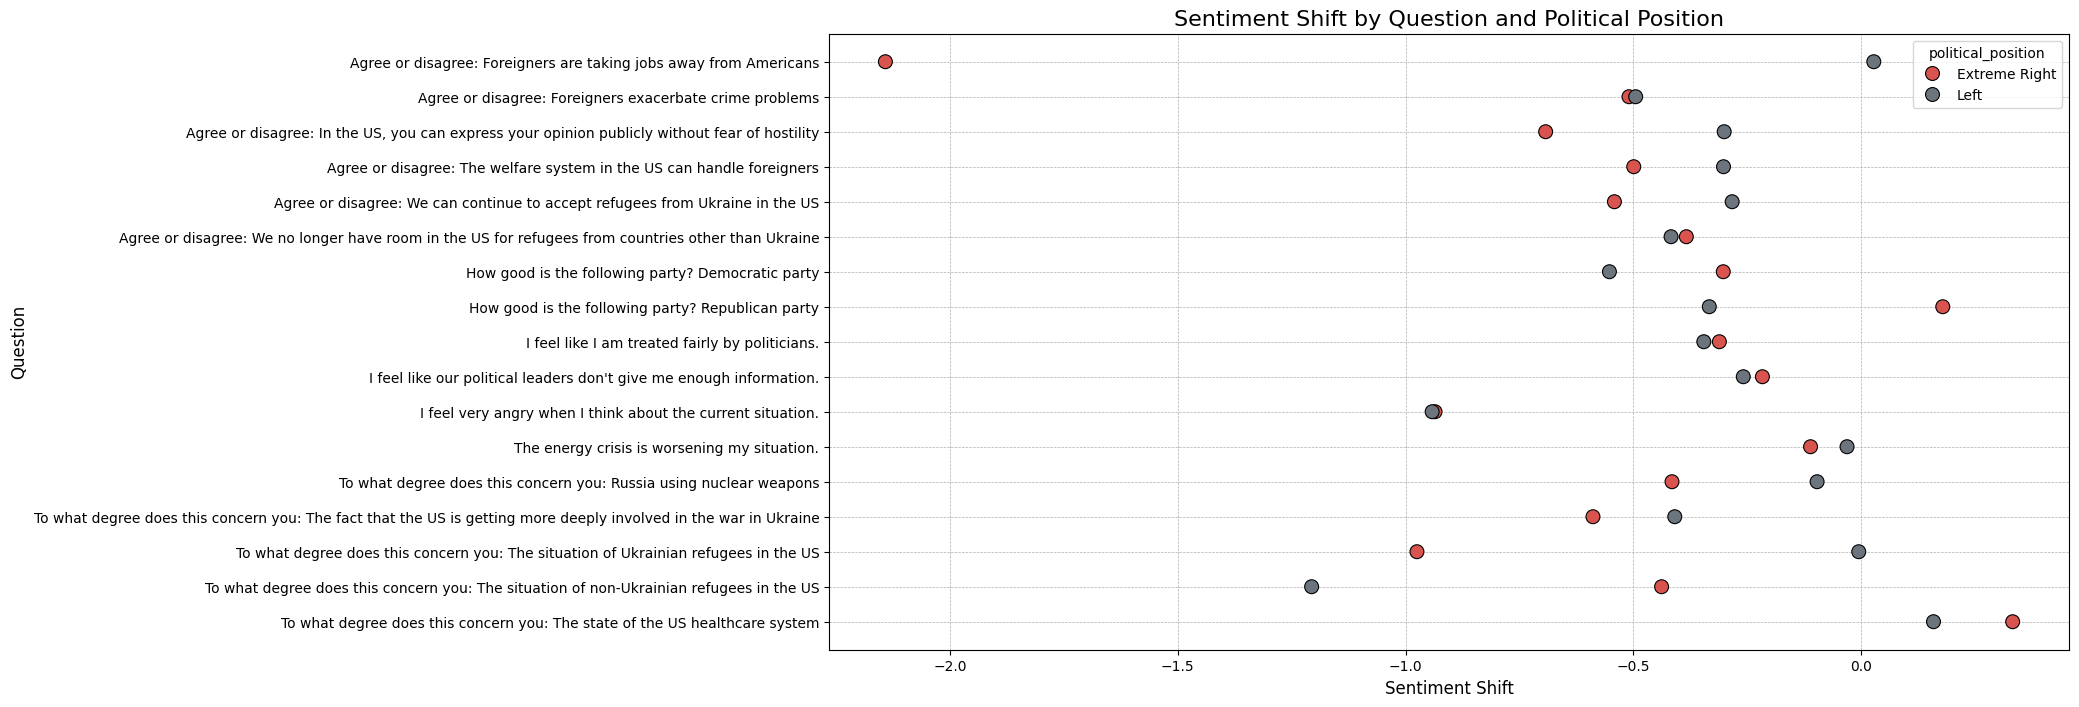

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Load the question-to-topic mapping
with open('../data/raw/question_to_topic.json', 'r') as f:
    question_to_topic = json.load(f)['question_to_topic']

# Ensure that merged_df is loaded or created
# merged_df = pd.read_csv('path_to_your_data.csv')  # Load your data here

# Map questions to topics in merged_df
merged_df['topic'] = merged_df['question'].map(question_to_topic)

# Merge 'Extreme Left' and 'Far Left' into 'Left'
merged_df['political_position'] = merged_df['political_position'].replace({'Extreme Left': 'Left', 'Far Left': 'Left'})

# Check if "Left" data exists before grouping
print("Political position distribution before grouping:")
print(merged_df['political_position'].value_counts())

# Group by question and political position, then calculate sentiment shifts
question_level_shifts = merged_df.groupby(['question', 'political_position']).agg({
    'before_sentiment': 'mean',
    'after_sentiment': 'mean'
}).reset_index()

# Calculate the sentiment shift and add it to the question_level_shifts DataFrame
question_level_shifts['sentiment_shift'] = question_level_shifts['after_sentiment'] - question_level_shifts['before_sentiment']

# Check the resulting DataFrame for "Left" and "Extreme Right"
print("Grouped Data (question_level_shifts):")
print(question_level_shifts['political_position'].value_counts())

# If "Left" is missing, we need to handle it explicitly (e.g., if there is no data for it)
# Define a simplified palette that covers the merged political positions
palette = {
    'Left': '#6C757D', 
    'Extreme Right': '#D9534F'
}

# Adjust the figure size
plt.figure(figsize=(16, 8))

# Create a scatterplot to visualize sentiment shifts by question and political position
sns.scatterplot(x='sentiment_shift', y='question', hue='political_position', 
                data=question_level_shifts, palette=palette, s=100, edgecolor='black', zorder=3)

# Add title and labels
plt.title('Sentiment Shift by Question and Political Position', fontsize=16)
plt.xlabel('Sentiment Shift', fontsize=12)
plt.ylabel('Question', fontsize=12)

# Rotate the y-axis labels for better readability
plt.yticks(fontsize=10)  # Adjust font size for y-axis labels

# Add grid to the plot for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()


#### Considering Article Sentiment


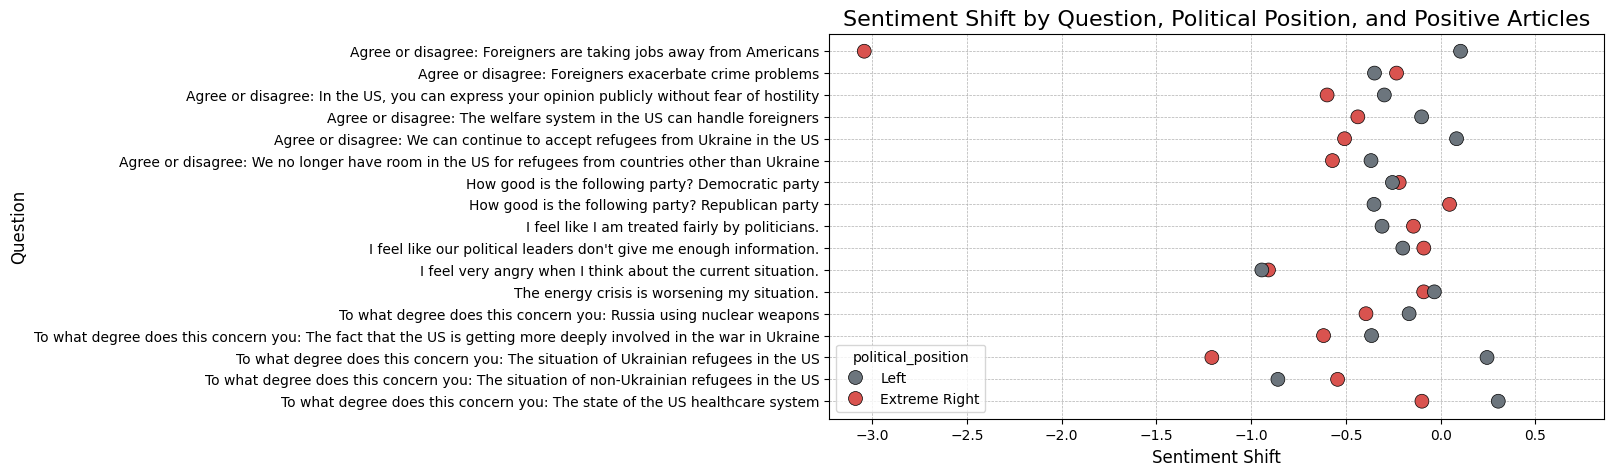

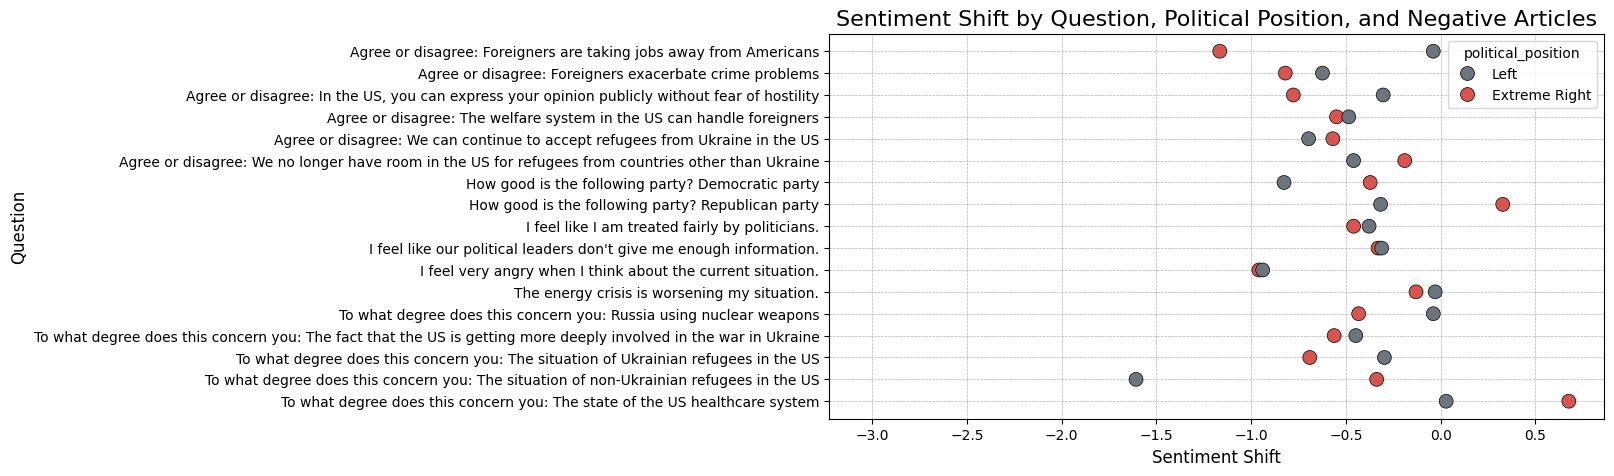

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Load the question-to-topic mapping
with open('../data/raw/question_to_topic.json', 'r') as f:
    question_to_topic = json.load(f)['question_to_topic']

# Map questions to topics in merged_df
merged_df['topic'] = merged_df['question'].map(question_to_topic)

# Determine if articles are positive or negative
positive_sentiment_threshold = 3  # Threshold above which sentiment is considered positive
merged_df['article_type'] = merged_df['article_sentiment'].apply(lambda x: 'Positive' if x > positive_sentiment_threshold else 'Negative')

# Group by question, political_position, and article_type to calculate sentiment shifts
question_level_shifts = merged_df.groupby(['question', 'political_position', 'article_type']).agg({
    'before_sentiment': 'mean',
    'after_sentiment': 'mean'
}).reset_index()

# Calculate the sentiment shift
question_level_shifts['sentiment_shift'] = question_level_shifts['after_sentiment'] - question_level_shifts['before_sentiment']

# Ensure 'political_position' is treated as a categorical variable with both categories enforced
question_level_shifts['political_position'] = pd.Categorical(
    question_level_shifts['political_position'],
    categories=['Left', 'Extreme Right']
)

# Define color palette for political positions
palette = {
    'Left': '#6C757D', 
    'Extreme Right': '#D9534F'
}

# Find common x-axis limits (sentiment shift range) for both plots
x_min = question_level_shifts['sentiment_shift'].min()
x_max = question_level_shifts['sentiment_shift'].max()

# Add padding to x-axis limits (5% padding)
x_padding = (x_max - x_min) * 0.05
x_min_padded = x_min - x_padding
x_max_padded = x_max + x_padding

# Simplify the plot to scatter plot for debugging
for article_type in ['Positive', 'Negative']:
    fig, ax = plt.subplots(figsize=(10, 5))  # Adjusted figure size
    
    # Filter data for the current article type
    data_filtered = question_level_shifts[question_level_shifts['article_type'] == article_type]

    # Scatter plot with circular markers, borders, and grid for readability
    sns.scatterplot(x='sentiment_shift', y='question', hue='political_position', 
                    data=data_filtered, palette=palette, s=100, marker='o',
                    edgecolor='black', linewidth=0.5, ax=ax, zorder=3)

    # Set the padded x-axis limits for both plots
    ax.set_xlim(x_min_padded, x_max_padded)

    # Enable grid on the axes object directly
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)

    # Add title and labels
    ax.set_title(f'Sentiment Shift by Question, Political Position, and {article_type} Articles', fontsize=16)
    ax.set_xlabel('Sentiment Shift', fontsize=12)
    ax.set_ylabel('Question', fontsize=12)

    plt.show()


In [ ]:
#